In [1]:
import puma
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from ftag import Cuts
from ftag.hdf5 import H5Reader

In [2]:
reader = H5Reader('/eos/home-a/anmilici/ntupla.h5', batch_size=10000)
data = reader.load({"jets": ["pt", "eta","PartonTruthLabelID",
                             "HadronConeExclTruthLabelID",
                             "HadronConeExclTruthLabelPdgId",
                             "n_tracks","eventNumber"],
                    "tracks":["pt","qOverP",
                              "ftagTruthOriginLabel",
                              "ftagTruthTypeLabel",
                              "ftagTruthSourceLabel",
                              "ftagTruthVertexIndex",
                              "GN2v01_aux_TrackOrigin",
                              "GN2v01_aux_VertexIndex",
                              "leptonID",
                              "valid"]}, num_jets=500000)

In [3]:
flavour_cuts = Cuts.from_list([("PartonTruthLabelID", "==", 5),("HadronConeExclTruthLabelID","==",5)])
#in this way i select jets tagged with bjets at parton level and which contain at least a bhadron (shall i use HadronConeExtendedExclTruthLabelID ?)

idx,bjets=flavour_cuts(data["jets"])
tracks=data["tracks"][idx]

print("nbjets=",len(bjets))
print("ntracks=",len(tracks))

nbjets= 184306
ntracks= 184306


In [4]:
'''
neutral bhadrons from all the possible values of HadronConeExclTruthLabelPdgI [511,531,551,553,555,5122,5232,-511,-531,-551,-553,-555,-5122,-5232]
'''
removed_bhadrons_list=[0,-0,541,   531,   511,   551,   553,   555,  5122,  5132,5232,  5332,   431,   421,   411,   441,   443,   445,  4122,4132,  4232,  4332,  4322,    15,  -541,  -531,  -511,
                      -551,  -553,  -555, -5122, -5132, -5232, -5332,  -431,  -421, -411,  -441,  -443,  -445, -4122, -4132, -4232, -4332, -4322, -15]

charged_Bmesons_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","!=",x) for x in removed_bhadrons_list])
index,charged_bjets=charged_Bmesons_cut(bjets)
charged_tracks=tracks[index]

Bplus_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","==",521)])
plus_index,Bplus=Bplus_cut(charged_bjets)

Bplus_tracks=charged_tracks[plus_index]

Bminus_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","==",-521)])
minus_index,Bminus=Bminus_cut(charged_bjets)

Bminus_tracks=charged_tracks[minus_index]

#total number of jet with a charged B hadron we are looking at

ncharged=len(charged_bjets)

npos=len(Bplus)
nneg=len(Bminus)

assert all(np.isin(charged_bjets["HadronConeExclTruthLabelPdgId"], [521, -521])), "There are jets with HadronConeExclTruthLabelPdgId other than 521 and -521 in charged_bjets"
print("number of charged bjet=",ncharged)
print("truth positive=",npos)
print("truth negative=",nneg)

number of charged bjet= 79116
truth positive= 39502
truth negative= 39614


# Charge Algorithm

In [5]:
def charge_algorithm(index,tracks,
                     mode:str):
  string=' '

  if mode=="GN2":
    string='GN2v01_aux_TrackOrigin'
  elif mode=='truth':
    string='ftagTruthOriginLabel'

  #cutting on all the tracks that has not ftagTruthOriginLabel == 3(fromB) or 4(fromBC)

  truth_fromB_BC_cuts=Cuts.from_list([(string,"!=",0),
                                      (string,"!=",1),
                                      (string,"!=",2),
                                      (string,"!=",5),
                                      (string,"!=",6),
                                      (string,"!=",7),    
                                      ("valid","==",True)])
  
  secondaries=truth_fromB_BC_cuts(tracks).values
  charge=np.sign(secondaries["qOverP"]).sum()
  return charge

# Weighted Charge Algorithm

In [6]:
def weighted_charge_algorithm(index,tracks,k=0.3):
    pt_jet=0
    Q=0
    tracks=tracks[tracks["valid"]==True]
    for i,track in enumerate(tracks):

        Q+=np.sign(track["qOverP"])*np.power(track["pt"],k)
        pt_jet+=track["pt"]
        
    return Q/np.power(pt_jet,k)

# Con not decided


/tmp/anmilici/ipykernel_312768/3730823353.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return Q/np.power(pt_jet,k)


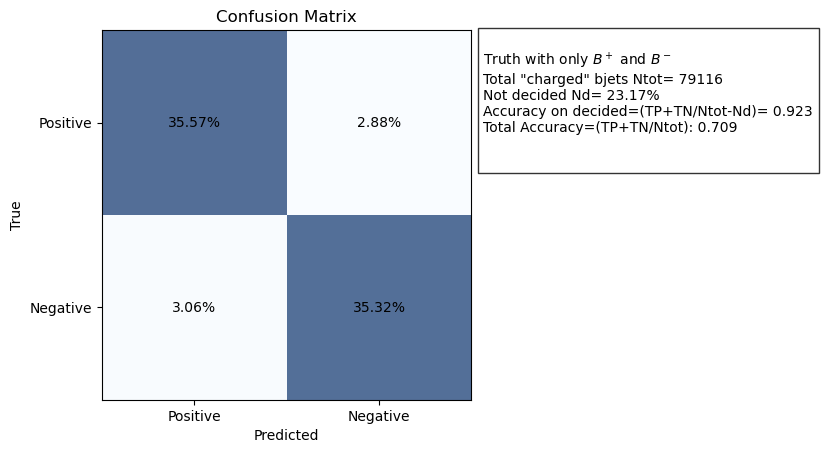

In [7]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]
weighted_charge=[]
k=0.29
not_decided_indexes=[]


for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'truth')
  weighted_Q=weighted_charge_algorithm(i,charged_tracks[i],k)
  weighted_charge.append(weighted_Q)

  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:

    not_decided_indexes.append(i)
    not_decided+=1

  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    print("charge SUM=",charge)
    print("\n")
    if i>200:
        break

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')



text_box = f"""
Truth with only $B^+$ and $B^-$
Total "charged" bjets Ntot= {ncharged}
Not decided Nd= {round(100*not_decided/ncharged,2)}%
Accuracy on decided=(TP+TN/Ntot-Nd)= {((confusion_matrix[0,0]+confusion_matrix[1,1])/(len(charged_bjets)-not_decided)).round(3)}
Total Accuracy=(TP+TN/Ntot): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}

"""
text=plt.gcf().text(0.82, 0.6, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))


plt.savefig('TRUTH_confusion_matrix.png', dpi=300, bbox_inches='tight')

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


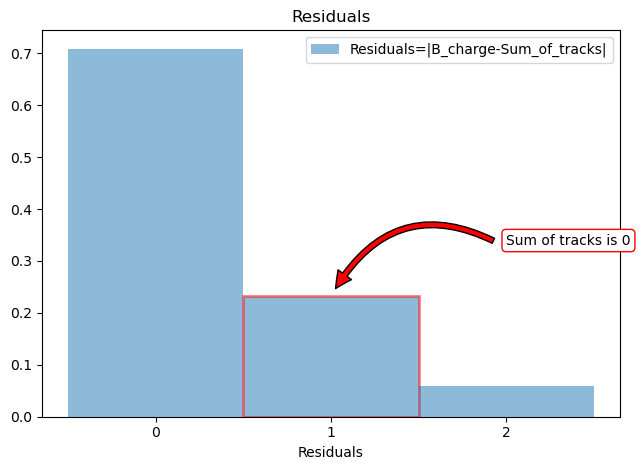

In [8]:
hist=plt.hist(residuals,bins=[-0.5,0.5,1.5,2.5],alpha=0.5,density=True)

plt.title('Residuals')

plt.xlabel('Residuals')
plt.xticks([0,1,2])
plt.tight_layout()
plt.legend(['Residuals=|B_charge-Sum_of_tracks|'])
plt.gca().patches[1].set_edgecolor('red')
plt.gca().patches[1].set_linewidth(2)
plt.annotate('Sum of tracks is 0', xy=(1, hist[0][1]), xytext=(2, hist[0][1] + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05, connectionstyle="arc3,rad=.5"),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white'))

plt.savefig('Residuals_truth.png', dpi=300, bbox_inches='tight')
plt.show()


# Con random choice per not decided

/tmp/anmilici/ipykernel_312768/3730823353.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return Q/np.power(pt_jet,k)


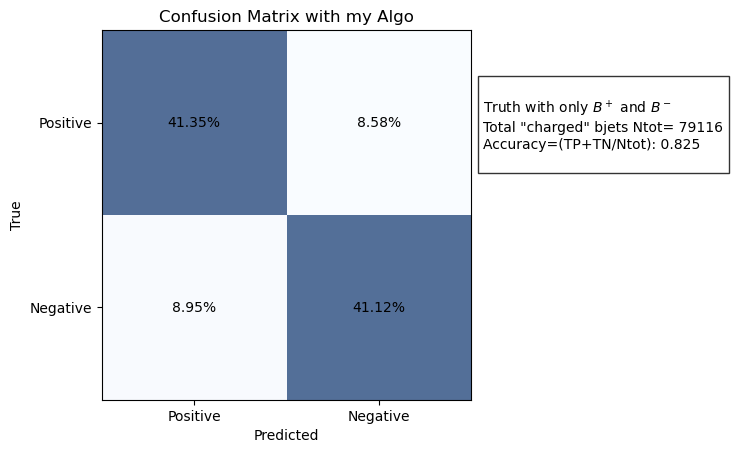

In [9]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]
weighted_charge=[]
k=0.29

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'truth')
  weighted_Q=weighted_charge_algorithm(i,charged_tracks[i],k)
  weighted_charge.append(weighted_Q)

  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:
    
    #charge=weighted_charge_algorithm(i,charged_tracks[i],k)
    charge=np.random.choice([-1,1])

    if jet["HadronConeExclTruthLabelPdgId"]>0:

        if charge>0:
            confusion_matrix[0,0]+=1
        elif charge<0:
            confusion_matrix[0,1]+=1

    elif jet["HadronConeExclTruthLabelPdgId"]<0:
        if charge>0:
          confusion_matrix[1,0]+=1
        elif charge<0:
         confusion_matrix[1,1]+=1
  

  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    print("charge SUM=",charge)
    print("\n")
    if i>200:
        break

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix with my Algo')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')



text_box = f"""
Truth with only $B^+$ and $B^-$
Total "charged" bjets Ntot= {ncharged}
Accuracy=(TP+TN/Ntot): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}
"""
text=plt.gcf().text(0.82, 0.6, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.savefig('TRUTH_cm.png', dpi=300, bbox_inches='tight')

# Weighted Charge


/tmp/anmilici/ipykernel_312768/3730823353.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return Q/np.power(pt_jet,k)


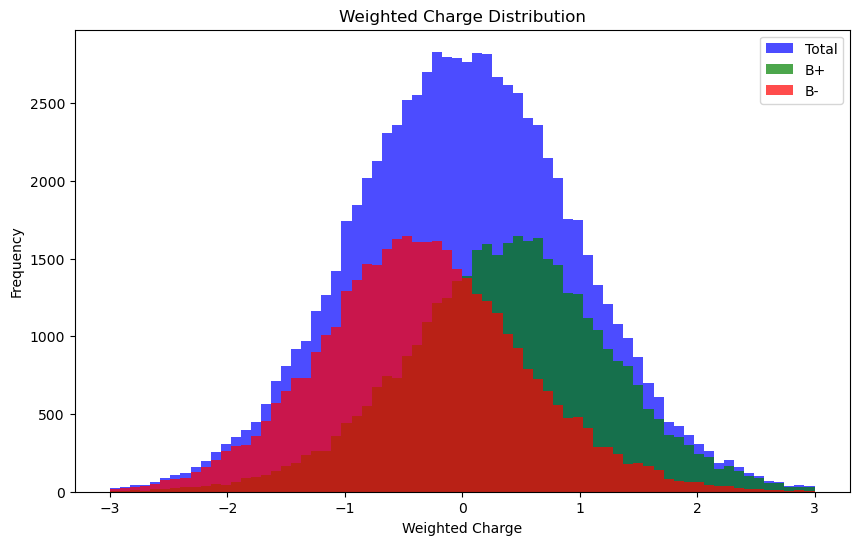

In [10]:
Bplus_weighted_charge=[]
Bminus_weighted_charge=[]
k=0.29
for i,jet in enumerate(Bplus):

  charge=charge_algorithm(i,Bplus_tracks[i],'truth')
  weighted_Q=weighted_charge_algorithm(i,Bplus_tracks[i],k)
  Bplus_weighted_charge.append(weighted_Q)

for i,jet in enumerate(Bminus):

  charge=charge_algorithm(i,Bminus_tracks[i],'truth')
  weighted_Q=weighted_charge_algorithm(i,Bminus_tracks[i],k)
  Bminus_weighted_charge.append(weighted_Q)

plt.figure(figsize=(10, 6))

# Plot histograms
htot = plt.hist(weighted_charge, bins=70, range=(-3, 3), color='blue', alpha=0.7, label='Total')
hplus = plt.hist(Bplus_weighted_charge, bins=70, range=(-3, 3), color='green', alpha=0.7, label='B+')
hminus = plt.hist(Bminus_weighted_charge, bins=70, range=(-3, 3), color='red', alpha=0.7, label='B-')

# Add titles and labels
plt.title('Weighted Charge Distribution')
plt.xlabel('Weighted Charge')
plt.ylabel('Frequency')
plt.legend()

Bplus_weighted_charge=np.array(Bplus_weighted_charge)
Bminus_weighted_charge=np.array(Bminus_weighted_charge)


plt.savefig('Weighted_charge.png', dpi=300, bbox_inches='tight')

/tmp/anmilici/ipykernel_312768/3730823353.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return Q/np.power(pt_jet,k)


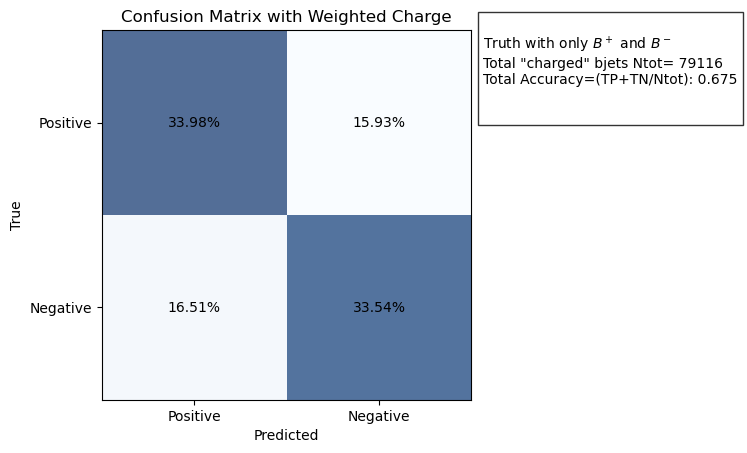

In [11]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]
weighted_charge=[]
k=0.29

for i,jet in enumerate(charged_bjets):

  charge=weighted_charge_algorithm(i,charged_tracks[i],k)
  weighted_charge.append(charge)

  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  
  if charge==0:
     not_decided+=1
    
  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    print("charge SUM=",charge)
    print("\n")
    if i>200:
        break

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix with Weighted Charge')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')



text_box = f"""
Truth with only $B^+$ and $B^-$
Total "charged" bjets Ntot= {ncharged}
Total Accuracy=(TP+TN/Ntot): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}

"""
text=plt.gcf().text(0.82, 0.7, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.savefig('TRUTH_cm_weighetQ.png', dpi=300, bbox_inches='tight')

# GN2 prediction

# GN2 con not decided

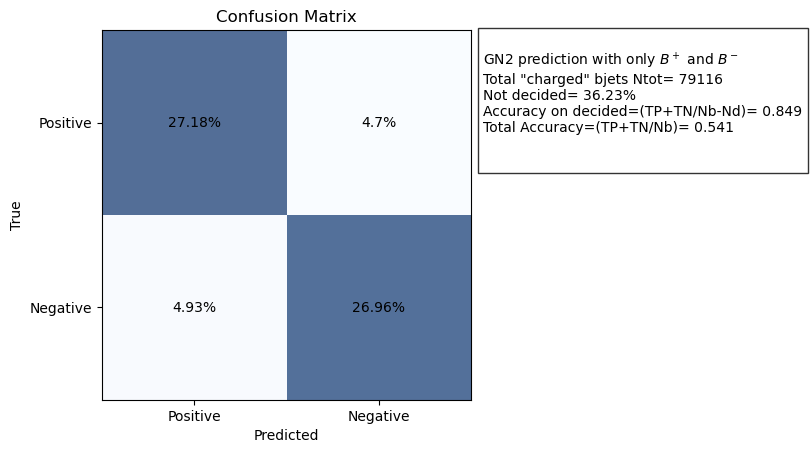

In [12]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'GN2')

  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:
    not_decided+=1

  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    print("charge SUM=",charge)
    print("\n")
    if i>200:
        break

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')



text_box = f"""
GN2 prediction with only $B^+$ and $B^-$
Total "charged" bjets Ntot= {ncharged}
Not decided= {round(100*not_decided/ncharged,2)}%
Accuracy on decided=(TP+TN/Nb-Nd)= {((confusion_matrix[0,0]+confusion_matrix[1,1])/(len(charged_bjets)-not_decided)).round(3)}
Total Accuracy=(TP+TN/Nb)= {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}

"""
text=plt.gcf().text(0.82, 0.6, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.savefig('GN2_confusion_mat.png', dpi=300, bbox_inches='tight')

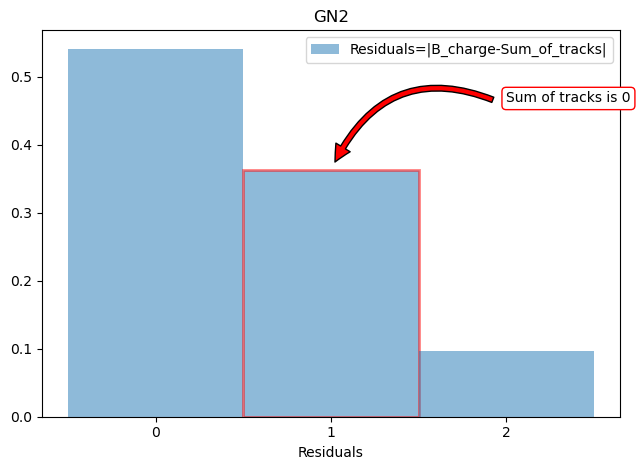

In [13]:
hist=plt.hist(residuals,bins=[-0.5,0.5,1.5,2.5],alpha=0.5,density=True)

plt.title('GN2')

plt.xlabel('Residuals')
plt.xticks([0,1,2])
plt.tight_layout()
plt.legend(['Residuals=|B_charge-Sum_of_tracks|'])
plt.gca().patches[1].set_edgecolor('red')
plt.gca().patches[1].set_linewidth(2)
plt.annotate('Sum of tracks is 0', xy=(1, hist[0][1]), xytext=(2, hist[0][1] + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05, connectionstyle="arc3,rad=.5"),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white'))

plt.savefig('Residuals_GN2.png', dpi=300, bbox_inches='tight')
plt.show()


# GN2 con random decision

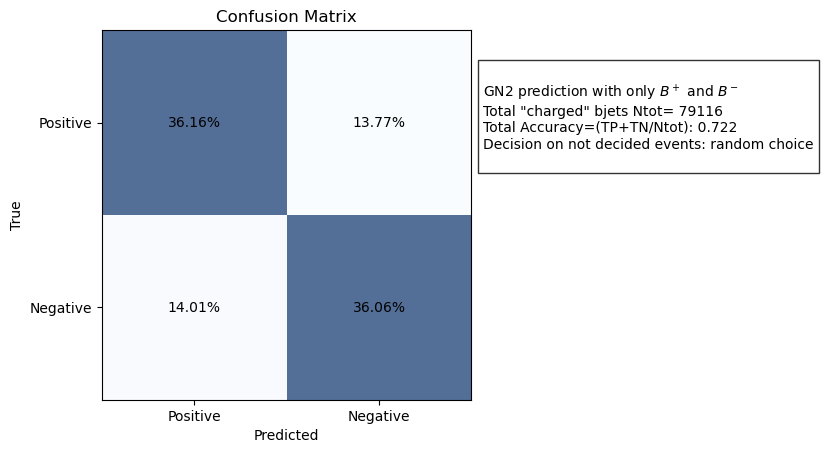

In [14]:
confusion_matrix=np.zeros((2,2))
debug=False
residuals=[]
k=0.29

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'GN2')
  
  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:
    
    
    charge=np.random.choice([-1,1])

    if jet["HadronConeExclTruthLabelPdgId"]>0:

        if charge>0:
            confusion_matrix[0,0]+=1
        elif charge<0:
            confusion_matrix[0,1]+=1

    elif jet["HadronConeExclTruthLabelPdgId"]<0:
        if charge>0:
          confusion_matrix[1,0]+=1
        elif charge<0:
         confusion_matrix[1,1]+=1
  

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')

text_box = f"""
GN2 prediction with only $B^+$ and $B^-$
Total "charged" bjets Ntot= {ncharged}
Total Accuracy=(TP+TN/Ntot): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}
Decision on not decided events: random choice
"""
text=plt.gcf().text(0.82, 0.6, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.savefig('GN2_cm_random.png', dpi=300, bbox_inches='tight')

# GN2 with weighted charge decision

/tmp/anmilici/ipykernel_312768/3730823353.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return Q/np.power(pt_jet,k)


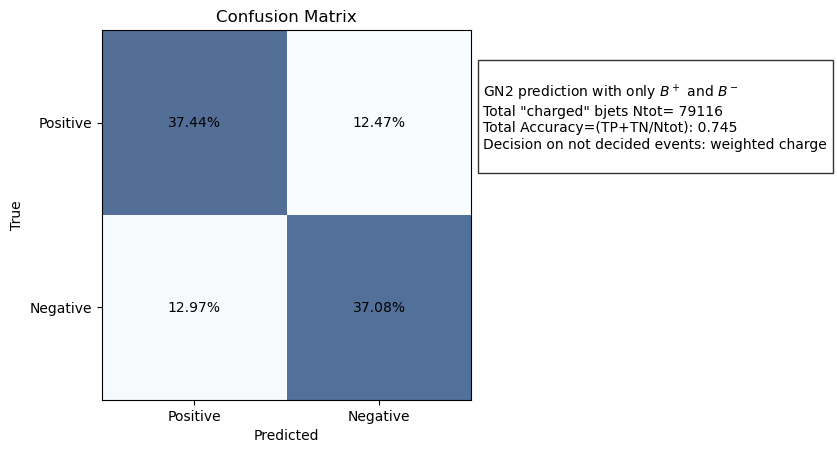

In [15]:
confusion_matrix=np.zeros((2,2))
debug=False
residuals=[]
k=0.29

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'GN2')
  
  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:
    
    charge=weighted_charge_algorithm(i,charged_tracks[i],k)
    

    if jet["HadronConeExclTruthLabelPdgId"]>0:

        if charge>0:
            confusion_matrix[0,0]+=1
        elif charge<0:
            confusion_matrix[0,1]+=1

    elif jet["HadronConeExclTruthLabelPdgId"]<0:
        if charge>0:
          confusion_matrix[1,0]+=1
        elif charge<0:
         confusion_matrix[1,1]+=1
  

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')

text_box = f"""
GN2 prediction with only $B^+$ and $B^-$
Total "charged" bjets Ntot= {ncharged}
Total Accuracy=(TP+TN/Ntot): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}
Decision on not decided events: weighted charge
"""
text=plt.gcf().text(0.82, 0.6, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.savefig('GN2_cm_weighted.png', dpi=300, bbox_inches='tight')

# Neutral B mesons

In [16]:

removed_bhadrons_list=[0,-0,541, 531,-531,521,   551,   553,   555,  5122,  5132,5232,  5332,   431,   421,   411,   441,   443,   445,  4122,4132,  4232,  4332,  4322,    15,  -541,  -521,
                      -551,  -553,  -555, -5122, -5132, -5232, -5332,  -431,  -421, -411,  -441,  -443,  -445, -4122, -4132, -4232, -4332, -4322, -15]

neutral_Bmesons_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","!=",x) for x in removed_bhadrons_list])
index,neutral_bjets=neutral_Bmesons_cut(bjets)
neutral_tracks=tracks[index]

n_neutral=len(neutral_bjets)

val,count=np.unique(neutral_bjets["HadronConeExclTruthLabelPdgId"],return_counts=True)

print("neutral bjets=",n_neutral)
print("B0=",count[0])
print("B0bar=",count[1])

neutral bjets= 79250
B0= 39348
B0bar= 39902


In [17]:
def neutral_charge_algorithm(index,tracks,
                     mode:str):
  string=' '

  if mode=="GN2":
    string='GN2v01_aux_TrackOrigin'
  elif mode=='truth':
    string='ftagTruthOriginLabel'

  #cutting on all the tracks that has not ftagTruthOriginLabel == 3(fromB) or 4(fromBC)

  truth_fromB_BC_cuts=Cuts.from_list([(string,"!=",0),
                                      (string,"!=",1),
                                      (string,"!=",5),
                                      (string,"!=",6),
                                      (string,"!=",7),
                                      ("valid","==",True)])
  
  secondaries=truth_fromB_BC_cuts(tracks).values
  charge=np.sign(secondaries["qOverP"]).sum()
  return charge

In [18]:
ev=4
print([str(x[0]) for x in neutral_bjets[ev].dtype.descr])
print([str(x[0]) for x in neutral_tracks[ev].dtype.descr])
print(neutral_bjets[ev])
tracce=neutral_tracks[ev][neutral_tracks[0]["valid"]==True]
tracce[tracce["ftagTruthOriginLabel"]==2]
tracce["ftagTruthTypeLabel"]

['pt', 'eta', 'n_tracks', 'HadronConeExclTruthLabelPdgId', 'HadronConeExclTruthLabelID', 'PartonTruthLabelID', 'eventNumber']
['GN2v01_aux_TrackOrigin', 'GN2v01_aux_VertexIndex', 'leptonID', 'ftagTruthOriginLabel', 'ftagTruthTypeLabel', 'ftagTruthSourceLabel', 'ftagTruthVertexIndex', 'qOverP', 'pt', 'valid']
(63219.8, 1.4975057, 9, -511, 5, 5, 40234990)


array([-2,  3, -2,  2, -2, -2,  0,  2,  2, -1, -1, -1], dtype=int32)

In [19]:
def neutral_tag(index,tracks,
                     mode:str):
  string=' '

  if mode=="GN2":
    string='GN2v01_aux_TrackOrigin'
  elif mode=='truth':
    string='ftagTruthOriginLabel'
  
  primary_tracks=tracks[tracks[string]==2]
  
  if len(primary_tracks)==0:
    return 0
   
    
    
  highest_pt_primary_track=primary_tracks[np.argmin(primary_tracks["pt"])]
  charge=np.sign(highest_pt_primary_track["qOverP"])

  return charge

/tmp/anmilici/ipykernel_312768/3730823353.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return Q/np.power(pt_jet,k)


17076


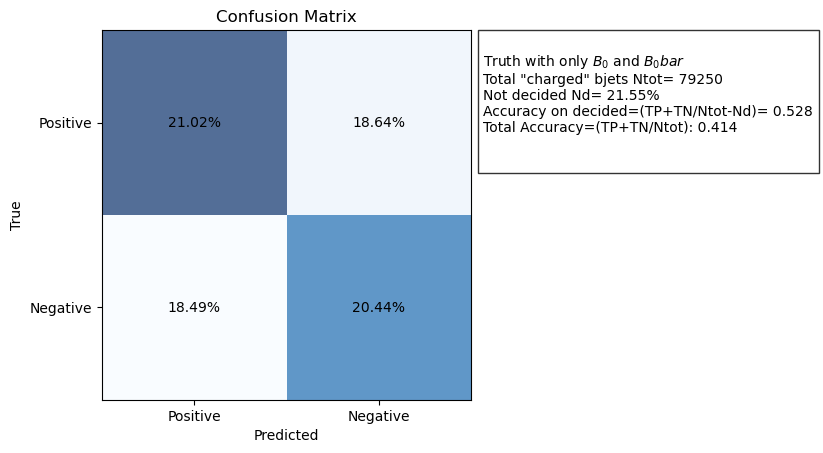

In [20]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0

weighted_charge=[]
sum_of_tracks=[]
k=0.29
not_decided_indexes=[]


for i,jet in enumerate(neutral_bjets):

  #charge=neutral_charge_algorithm(i,neutral_tracks[i],'truth')
  charge=neutral_tag(i,neutral_tracks[i],'GN2')
  weighted_Q=weighted_charge_algorithm(i,neutral_tracks[i],k)
  weighted_charge.append(weighted_Q)
  sum_of_tracks.append(charge)
  
  
  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1
  
  if charge==0:
      
      not_decided+=1
      not_decided_indexes.append(i)
      '''
      charge=weighted_charge_algorithm(i,neutral_tracks[i],k)
      
      if jet["HadronConeExclTruthLabelPdgId"]>0:

        if charge>0:
            confusion_matrix[0,0]+=1
        elif charge<0:
            confusion_matrix[0,1]+=1

      elif jet["HadronConeExclTruthLabelPdgId"]<0:
        
        if charge>0:
          confusion_matrix[1,0]+=1
        
        elif charge<0:
         confusion_matrix[1,1]+=1
    '''
      
     
  
# just plotting the confusion matrix
print(not_decided)


plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')



text_box = f"""
Truth with only $B_0$ and $B_0bar$
Total "charged" bjets Ntot= {n_neutral}
Not decided Nd= {round(100*not_decided/n_neutral,2)}%
Accuracy on decided=(TP+TN/Ntot-Nd)= {((confusion_matrix[0,0]+confusion_matrix[1,1])/(n_neutral-not_decided)).round(3)}
Total Accuracy=(TP+TN/Ntot): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / n_neutral).round(3)}

"""
text=plt.gcf().text(0.82, 0.6, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))


#plt.savefig('TRUTH_confusion_matrix.png', dpi=300, bbox_inches='tight')